In [1]:
import torch
from torch import nn
import torch.nn.init as init

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
import requests
from pathlib import Path
import os
from timeit import default_timer as timer
from tqdm.auto import tqdm
import math
from helper_functions import print_train_time
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from contextlib import nullcontext
import torch, torch.backends.cudnn as cudnn, torch.backends.cuda as cuda_bk

c:\Users\Altuk\OneDrive\repos\skill-builder-process\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = pick_device()

# CUDA-only speed toggles (guard them!)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True          # good for speed with static shapes
    torch.backends.cuda.matmul.allow_tf32 = True   # TF32 fast matmul on Ampere+
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")     # prefers fast float32 kernels

c:\Users\Altuk\OneDrive\repos\skill-builder-process\.venv\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

#Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
class_names = train_data.classes

NUM_CLASSES = len(class_names)
#Setup the batch size hyperparameter
BATCH_SIZE = 256


In [5]:


device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
# Device-aware loader settings
if device.type == "cuda":
    loader_kwargs = dict(
        batch_size=BATCH_SIZE,
        num_workers=max(4, os.cpu_count() // 2),
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
elif device.type == "mps":
    loader_kwargs = dict(
        batch_size=BATCH_SIZE,
        num_workers=0,          # multiprocessing not reliable on MPS
        pin_memory=False,
        persistent_workers=False
    )
else:  # CPU fallback
    loader_kwargs = dict(batch_size=BATCH_SIZE, num_workers=0)

In [7]:

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, shuffle=True, **loader_kwargs)
test_dataloader = DataLoader(dataset=test_data, shuffle=True, **loader_kwargs)

Text(0.5, 1.0, '9')

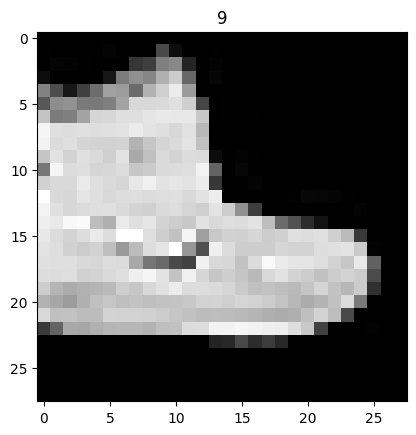

In [8]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

In [9]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
#Training func
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device | str = 'cpu',
               task: str = "multiclass",
               num_classes=None,
               scheduler: torch.optim.lr_scheduler._LRScheduler | None = None) -> tuple:
    """Performs one training epoch over data_loader."""

    # ---- setup ----
    if not isinstance(device, torch.device):
        device = torch.device(device)
    use_cuda = device.type == "cuda"
    use_mps  = device.type == "mps"

    model.train()
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)

    # AMP: unified, deprecation-safe
    # CUDA: use GradScaler + autocast("cuda", fp16)
    # MPS: use autocast("mps", fp16) if available; no scaler
    # CPU: no autocast (tiny nets), plain FP32
    if use_cuda:
        scaler = torch.amp.GradScaler("cuda")  # new API
        autocast_cm = torch.amp.autocast("cuda", dtype=torch.float16)
    else:
        scaler = None
        # Try MPS autocast (PyTorch ≥2.5); fallback if not supported
        if use_mps:
            try:
                autocast_cm = torch.amp.autocast("mps", dtype=torch.float16)
            except Exception:
                autocast_cm = nullcontext()
        else:
            autocast_cm = nullcontext()

    current_lr = optimizer.param_groups[0]["lr"]
    total_loss, total_n = 0.0, 0

    for X, y in tqdm(data_loader):
        non_block = use_cuda  # only helps on CUDA + pinned memory
        X = X.to(device, non_blocking=non_block)
        y = y.to(device, non_blocking=non_block)

        # Channels-last boosts CUDA convs; harmless elsewhere
        if use_cuda:
            X = X.contiguous(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cm:
            logits = model(X)
            batch_loss = loss_fn(logits, y)

        if scaler is not None:          # CUDA path
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:                            # MPS/CPU path
            batch_loss.backward()
            optimizer.step()

        # metrics/bookkeeping
        n = y.size(0)
        total_loss += batch_loss.detach().item() * n
        total_n    += n
        acc_metric.update(logits.detach(), y)

        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]

    avg_loss = total_loss / max(total_n, 1)
    avg_acc  = acc_metric.compute().item()
    print(f"Train loss: {avg_loss:.5f} | Train accuracy: {avg_acc*100:.2f}% | lr: {current_lr}")
    return avg_loss, avg_acc

In [ ]:
#Testing func

def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              device: torch.device | str = "cpu",
              task: str = "multiclass",
              num_classes=None) -> tuple:
    """Eval one epoch. Returns (avg_loss, avg_acc)."""
    if not isinstance(device, torch.device):
        device = torch.device(device)
    use_cuda = device.type == "cuda"
    use_mps  = device.type == "mps"

    model.eval()
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)

    # AMP autocast (no GradScaler needed for eval)
    if use_cuda:
        autocast_cm = torch.amp.autocast("cuda", dtype=torch.float16)
    elif use_mps:
        # available on recent PyTorch; fallback silently if unsupported
        try:
            autocast_cm = torch.amp.autocast("mps", dtype=torch.float16)
        except Exception:
            autocast_cm = nullcontext()
    else:
        autocast_cm = nullcontext()

    total_loss, total_n = 0.0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            non_block = use_cuda  # only helps on CUDA + pinned memory
            X = X.to(device, non_blocking=non_block)
            y = y.to(device, non_blocking=non_block)

            if use_cuda:
                X = X.contiguous(memory_format=torch.channels_last)

            with autocast_cm:
                logits = model(X)
                batch_loss = loss_fn(logits, y)

            n = y.size(0)
            total_loss += batch_loss.detach().item() * n
            total_n    += n
            acc_metric.update(logits.detach(), y)

    avg_loss = total_loss / max(total_n, 1)
    avg_acc  = acc_metric.compute().item()
    print(f"Test loss: {avg_loss:.5f} | Test accuracy: {avg_acc*100:.2f}%")
    return avg_loss, avg_acc


### Model 2: Builing a Convolutional NN 

In [12]:
class FashionMNISTModelV2(nn.Module):
    """
    TinyVGG-style CNN for 28x28 Fashion-MNIST.
    Two conv blocks (3x3, ReLU, 3x3, ReLU, MaxPool2d(2)), then MLP head.
    Uses same-padding (p=1) so spatial dims are predictable; no dummy pass needed.
    """
    def __init__(self, input_shade: int,
                 hidden_units: int,
                 output_shape: int,
                 image_size: int = 28,
                 use_channels_last: bool = False,
                 init_kaiming: bool = True,
                 dropout_p:int = 0.10):
        super().__init__()
        self.image_size = image_size
        self.use_channels_last = use_channels_last

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shade, hidden_units, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 28->14
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 14->7
        )

        # With p=1, stride=1, two pools(2): side = image_size // 4
        side = image_size // 4
        flattened = hidden_units * side * side

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_p),
            nn.Linear(flattened, hidden_units),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_units, output_shape)
        )

        if init_kaiming:
            self._init_weights()

        # Optional memory format for faster CUDA convs (harmless elsewhere)
        if self.use_channels_last:
            self.to(memory_format=torch.channels_last)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        # Make input channels-last if requested (helps on CUDA + AMP)
        if self.use_channels_last and x.is_contiguous(memory_format=torch.contiguous_format):
            x = x.contiguous(memory_format=torch.channels_last)

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [21]:
class FashionMNISTModelV3(nn.Module):
    """
    TinyVGG-style CNN for 28x28 Fashion-MNIST.
    Two conv blocks (3x3, ReLU, 3x3, ReLU, MaxPool2d(2)), then MLP head.
    Uses same-padding (p=1) so spatial dims are predictable; no dummy pass needed.
    """
    def __init__(self, input_shade: int,
                 hidden_units: int,
                 output_shape: int,
                 image_size: int = 28,
                 use_channels_last: bool = False,
                 init_kaiming: bool = True,
                 dropout_p:int = 0.10):
        super().__init__()
        self.image_size = image_size
        self.use_channels_last = use_channels_last

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shade, hidden_units, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 28->14
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 14->7
        )

        # With p=1, stride=1, two pools(2): side = image_size // 4
        side = image_size // 4
        flattened = hidden_units * side * side

        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Dropout(p=dropout_p),
            nn.Linear(flattened, hidden_units),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_units, output_shape)
        )

        if init_kaiming:
            self._init_weights()

        # Optional memory format for faster CUDA convs (harmless elsewhere)
        if self.use_channels_last:
            self.to(memory_format=torch.channels_last)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        # Make input channels-last if requested (helps on CUDA + AMP)
        if self.use_channels_last and x.is_contiguous(memory_format=torch.contiguous_format):
            x = x.contiguous(memory_format=torch.channels_last)

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [13]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shade=1,
    hidden_units=64,            # for your 95% push
    output_shape=NUM_CLASSES,
    use_channels_last=(device.type == "cuda"),
    dropout_p=0.10
).to(device)

In [22]:
sum(p.numel() for p in model_2.parameters())

313098

In [15]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_2.parameters(),
    lr=1e-3,              # base lr (will be overridden by OneCycle)
    weight_decay=5e-4     # mild regularization, helps generalization
)

EPOCHS = 50

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,                 # peak LR
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.3,               # 30% warm-up phase
    anneal_strategy='cos',       # smoother decay
    div_factor=10,               # initial lr = max_lr / 10
    final_div_factor=10          # final lr = max_lr / 100
)

In [28]:
def train_test_loop(history: list,
                    model: nn.Module,
                    train_data_loader: torch.utils.data.DataLoader,
                    test_data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device | str = 'cpu',
                    num_classes: int = 10,
                    scheduler: torch.optim.lr_scheduler._LRScheduler | None = None,
                    epochs: int = 10,
                    timer_fn=timer,
                    log_path: str | None | Path = None):

    # normalize device
    if not isinstance(device, torch.device):
        device = torch.device(device)

    path = Path(log_path) if log_path is not None else Path("csv/history_model.csv")
    path.parent.mkdir(parents=True, exist_ok=True)
    cols = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr", "elapsed_s"]

    t0 = timer_fn()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}\n-------")

        # train (your train_step already handles AMP/scheduler-per-batch)
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_data_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           num_classes=num_classes,
                                           scheduler=scheduler)

        # eval
        test_loss, test_acc = test_step(model=model,
                                        loss_fn=loss_fn,
                                        data_loader=test_data_loader,
                                        device=device,
                                        num_classes=num_classes)

        # LR logging (robust to schedulers that don't expose get_last_lr)
        try:
            lr = scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]["lr"]
        except Exception:
            lr = optimizer.param_groups[0]["lr"]

        # accurate wall time on CUDA (sync before reading timer)
        if device.type == "cuda":
            torch.cuda.synchronize()
        elapsed = timer_fn() - t0

        row = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc":  train_acc,
            "val_loss":   test_loss,
            "val_acc":    test_acc,
            "lr":         lr,
            "elapsed_s":  elapsed
        }
        history.append(row)

        # append one row per epoch
        """pd.DataFrame([row], columns=cols).to_csv(
            path,
            sep=",",
            mode="a",
            header=not path.exists(),
            index=False
        )"""

    # fix the f-string (don’t wrap path in braces)
    print(f"Training finished in {timer_fn() - t0:.2f}s. Logs saved to history. Log after the training is finished")
    return history

In [17]:
"""from pathlib import Path

# --- Training Loop ---
history = []
epochs = 20
train_start_time = timer()

# Create directory for saving results
Path("csv").mkdir(parents=True, exist_ok=True)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}\n-------" )
    train_loss, train_acc = train_step(model=model_2,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       num_classes=NUM_CLASSES,
                                       scheduler=scheduler)

    test_loss, test_acc = test_step(model=model_2,
                                    loss_fn=loss_fn,
                                    data_loader=test_dataloader,
                                    device=device,
                                    num_classes=NUM_CLASSES)

    lr = optimizer.param_groups[0]['lr']
    history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc":  train_acc,
            "val_loss":   test_loss,
            "val_acc":    test_acc,
            "lr":         lr,
            "elapsed_s":  timer() - train_start_time
        })
"""


'from pathlib import Path\n\n# --- Training Loop ---\nhistory = []\nepochs = 20\ntrain_start_time = timer()\n\n# Create directory for saving results\nPath("csv").mkdir(parents=True, exist_ok=True)\n\nfor epoch in tqdm(range(epochs)):\n    print(f"Epoch: {epoch + 1}\n-------" )\n    train_loss, train_acc = train_step(model=model_2,\n                                       data_loader=train_dataloader,\n                                       loss_fn=loss_fn,\n                                       optimizer=optimizer,\n                                       device=device,\n                                       num_classes=NUM_CLASSES,\n                                       scheduler=scheduler)\n\n    test_loss, test_acc = test_step(model=model_2,\n                                    loss_fn=loss_fn,\n                                    data_loader=test_dataloader,\n                                    device=device,\n                                    num_classes=NUM_CLASSES)\n\n    lr 

In [ ]:
@torch.inference_mode()
def collecting_preds(model: nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     device: torch.device):
    model.eval()
    y_trues, y_preds = [], []
    for X, y in data_loader:
        X = X.to(device); y = y.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1)
        y_trues.append(y.cpu())
        y_preds.append(preds.cpu())
    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds)

    return y_trues, y_preds

In [19]:
# Initialize
history = []
EPOCHS = 20

# Run train/eval loop
train_test_loop(
    history=history,
    model=model_2,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    num_classes=NUM_CLASSES,
    epochs=EPOCHS,
    scheduler=scheduler
)

# Convert once after training (the function already appends per epoch)
hist_df = pd.DataFrame(history)

# Quick sanity check
print(hist_df.tail(3))

# Save once at the end (more efficient than re-writing each epoch)
out_path = Path("csv/history_model3.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
hist_df.to_csv(out_path, index=False)
print(f"\nSaved final training history to {out_path.resolve()}")

Epoch: 1
-------


100%|██████████| 235/235 [00:29<00:00,  7.92it/s]


Train loss: 1.01878 | Train accuracy: 78.01% | lr: 0.000329517422852736


100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Test loss: 0.84018 | Test accuracy: 85.90%
Epoch: 2
-------


100%|██████████| 235/235 [00:17<00:00, 13.65it/s]


Train loss: 0.83496 | Train accuracy: 86.06% | lr: 0.00041677890881558575


100%|██████████| 40/40 [00:00<00:00, 180.95it/s]


Test loss: 0.80170 | Test accuracy: 87.62%
Epoch: 3
-------


100%|██████████| 235/235 [00:17<00:00, 13.66it/s]


Train loss: 0.79771 | Train accuracy: 87.63% | lr: 0.0005579685553997742


100%|██████████| 40/40 [00:00<00:00, 164.99it/s]


Test loss: 0.77159 | Test accuracy: 88.89%
Epoch: 4
-------


100%|██████████| 235/235 [00:17<00:00, 13.66it/s]


Train loss: 0.76948 | Train accuracy: 88.80% | lr: 0.0007469122077895167


100%|██████████| 40/40 [00:00<00:00, 167.42it/s]


Test loss: 0.75946 | Test accuracy: 88.81%
Epoch: 5
-------


100%|██████████| 235/235 [00:17<00:00, 13.63it/s]


Train loss: 0.75433 | Train accuracy: 89.54% | lr: 0.000975347451639734


100%|██████████| 40/40 [00:00<00:00, 171.33it/s]


Test loss: 0.78000 | Test accuracy: 87.99%
Epoch: 6
-------


100%|██████████| 235/235 [00:17<00:00, 13.65it/s]


Train loss: 0.74976 | Train accuracy: 89.60% | lr: 0.00123328492445088


100%|██████████| 40/40 [00:00<00:00, 169.34it/s]


Test loss: 0.72816 | Test accuracy: 90.46%
Epoch: 7
-------


100%|██████████| 235/235 [00:17<00:00, 13.62it/s]


Train loss: 0.73668 | Train accuracy: 90.38% | lr: 0.0015094451455495708


100%|██████████| 40/40 [00:00<00:00, 164.43it/s]


Test loss: 0.72901 | Test accuracy: 90.60%
Epoch: 8
-------


100%|██████████| 235/235 [00:17<00:00, 13.63it/s]


Train loss: 0.72708 | Train accuracy: 90.70% | lr: 0.0017917517623116963


100%|██████████| 40/40 [00:00<00:00, 172.27it/s]


Test loss: 0.72723 | Test accuracy: 90.75%
Epoch: 9
-------


100%|██████████| 235/235 [00:17<00:00, 13.62it/s]


Train loss: 0.71978 | Train accuracy: 90.96% | lr: 0.0020678596432097103


100%|██████████| 40/40 [00:00<00:00, 173.37it/s]


Test loss: 0.73667 | Test accuracy: 89.74%
Epoch: 10
-------


100%|██████████| 235/235 [00:17<00:00, 13.62it/s]


Train loss: 0.71698 | Train accuracy: 91.05% | lr: 0.0023256947244311103


100%|██████████| 40/40 [00:00<00:00, 178.84it/s]


Test loss: 0.71574 | Test accuracy: 91.12%
Epoch: 11
-------


100%|██████████| 235/235 [00:17<00:00, 13.61it/s]


Train loss: 0.71084 | Train accuracy: 91.28% | lr: 0.002553982002837109


100%|██████████| 40/40 [00:00<00:00, 173.66it/s]


Test loss: 0.72016 | Test accuracy: 90.86%
Epoch: 12
-------


100%|██████████| 235/235 [00:17<00:00, 13.57it/s]


Train loss: 0.70667 | Train accuracy: 91.42% | lr: 0.0027427385863853203


100%|██████████| 40/40 [00:00<00:00, 165.10it/s]


Test loss: 0.70201 | Test accuracy: 91.23%
Epoch: 13
-------


100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


Train loss: 0.70158 | Train accuracy: 91.68% | lr: 0.00288371024116044


100%|██████████| 40/40 [00:00<00:00, 162.81it/s]


Test loss: 0.70168 | Test accuracy: 91.28%
Epoch: 14
-------


100%|██████████| 235/235 [00:17<00:00, 13.65it/s]


Train loss: 0.69962 | Train accuracy: 91.84% | lr: 0.0029707323450228426


100%|██████████| 40/40 [00:00<00:00, 149.15it/s]


Test loss: 0.73572 | Test accuracy: 89.99%
Epoch: 15
-------


100%|██████████| 235/235 [00:17<00:00, 13.56it/s]


Train loss: 0.69873 | Train accuracy: 91.79% | lr: 0.002999999891676076


100%|██████████| 40/40 [00:00<00:00, 165.78it/s]


Test loss: 0.73392 | Test accuracy: 89.99%
Epoch: 16
-------


100%|██████████| 235/235 [00:17<00:00, 13.57it/s]


Train loss: 0.69654 | Train accuracy: 91.87% | lr: 0.0029939708747888974


100%|██████████| 40/40 [00:00<00:00, 163.48it/s]


Test loss: 0.75423 | Test accuracy: 89.79%
Epoch: 17
-------


100%|██████████| 235/235 [00:17<00:00, 13.46it/s]


Train loss: 0.69275 | Train accuracy: 91.98% | lr: 0.0029760340540387104


100%|██████████| 40/40 [00:00<00:00, 165.86it/s]


Test loss: 0.77148 | Test accuracy: 86.86%
Epoch: 18
-------


100%|██████████| 235/235 [00:17<00:00, 13.50it/s]


Train loss: 0.69273 | Train accuracy: 92.03% | lr: 0.0029463338461595155


100%|██████████| 40/40 [00:00<00:00, 166.22it/s]


Test loss: 0.73689 | Test accuracy: 90.36%
Epoch: 19
-------


100%|██████████| 235/235 [00:17<00:00, 13.51it/s]


Train loss: 0.69185 | Train accuracy: 92.03% | lr: 0.0029051093797617168


100%|██████████| 40/40 [00:00<00:00, 151.89it/s]


Test loss: 0.69628 | Test accuracy: 91.46%
Epoch: 20
-------


100%|██████████| 235/235 [00:17<00:00, 13.49it/s]


Train loss: 0.68924 | Train accuracy: 92.21% | lr: 0.0028526925700091553


100%|██████████| 40/40 [00:00<00:00, 165.73it/s]

Test loss: 0.72244 | Test accuracy: 90.45%
Training finished in 368.21s. Logs saved to: csv\history_model.csv
    epoch  train_loss  train_acc  val_loss  val_acc        lr   elapsed_s
17     18    0.692725   0.920283  0.736888   0.9036  0.002946  332.865091
18     19    0.691845   0.920283  0.696282   0.9146  0.002905  350.536524
19     20    0.689237   0.922133  0.722437   0.9045  0.002853  368.210482

Saved final training history to C:\Users\Altuk\OneDrive\repos\skill-builder-process\ml_basics\notebooks\DL\csv\history_model3.csv


In [20]:
y_true, y_pred = collecting_preds(model=model_2,
                                  data_loader=test_dataloader,
                                  device=device)
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      labels=range(NUM_CLASSES),
                      )
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
print("Per-class accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"{i:>2} {class_names[i]:<12}: {acc*100:5.1f}%")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Per-class accuracy:
 0 T-shirt/top :  83.7%
 1 Trouser     :  97.9%
 2 Pullover    :  90.2%
 3 Dress       :  91.2%
 4 Coat        :  70.0%
 5 Sandal      :  94.0%
 6 Shirt       :  85.7%
 7 Sneaker     :  99.2%
 8 Bag         :  98.3%
 9 Ankle boot  :  94.1%

Classification report:
              precision    recall  f1-score   support

 T-shirt/top      0.900     0.837     0.867      1000
     Trouser      0.996     0.979     0.987      1000
    Pullover      0.872     0.902     0.887      1000
       Dress      0.907     0.912     0.909      1000
        Coat      0.967     0.700     0.812      1000
      Sandal      0.995     0.940     0.967      1000
       Shirt      0.648     0.857     0.738      1000
     Sneaker      0.902     0.992     0.945      1000
         Bag      0.986     0.983     0.984      1000
  Ankle boot      0.982     0.941     0.961      1000

    accuracy                          0.904     10000
   macro avg      0.915     0.904     0.906     10000
weighted avg

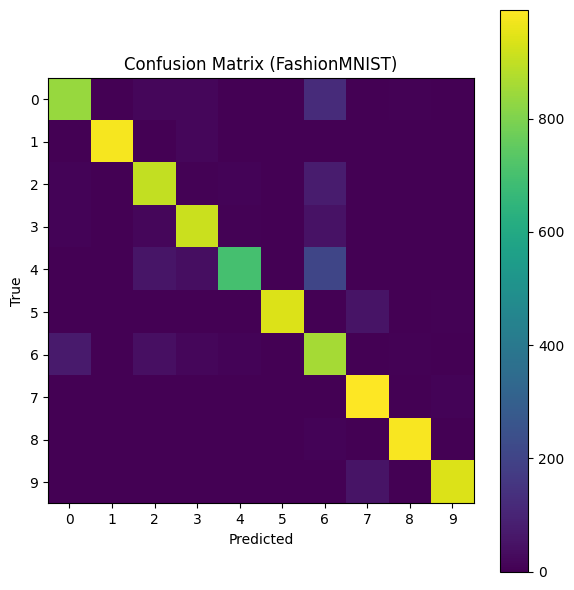

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(NUM_CLASSES)); ax.set_yticks(range(NUM_CLASSES))
ax.set_xticklabels(range(NUM_CLASSES)); ax.set_yticklabels(range(NUM_CLASSES))
ax.set_title("Confusion Matrix (FashionMNIST)")
plt.tight_layout(); plt.show()

In [ ]:
import random 

tensor([1, 6, 1,  ..., 9, 7, 1])

In [ ]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample enumerate(y_pred)

In [ ]:
torch.manual_seed(42)
model_3 = FashionMNISTModelV3(
    input_shade=1,
    hidden_units=64,           
    output_shape=NUM_CLASSES,
    use_channels_last=(device.type == "cuda"),
    dropout_p=0.10
).to(device)



In [25]:
loss_fn3 = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer3 = torch.optim.Adam(
    model_3.parameters(),
    lr=1e-3,              # base lr (will be overridden by OneCycle)
    weight_decay=5e-4     # mild regularization, helps generalization
)

EPOCHS = 20

scheduler3 = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,                 # peak LR
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.3,               # 30% warm-up phase
    anneal_strategy='cos',       # smoother decay
    div_factor=10,               # initial lr = max_lr / 10
    final_div_factor=10          # final lr = max_lr / 100
)

In [26]:
# Initialize
history = []
EPOCHS = 20

# Run train/eval loop
train_test_loop(
    history=history,
    model=model_3,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn3,
    optimizer=optimizer3,
    device=device,
    num_classes=NUM_CLASSES,
    epochs=EPOCHS,
    scheduler=scheduler3
)

# Convert once after training (the function already appends per epoch)
hist_df = pd.DataFrame(history)

# Quick sanity check
print(hist_df.tail(3))

# Save once at the end (more efficient than re-writing each epoch)
out_path = Path("csv/history_model3_3.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
hist_df.to_csv(out_path, index=False)

print(f"\nSaved final training history to {out_path.resolve()}")

Epoch: 1
-------


100%|██████████| 235/235 [00:02<00:00, 82.32it/s]


Train loss: 1.06525 | Train accuracy: 75.36% | lr: 0.00048111662249735246


100%|██████████| 40/40 [00:00<00:00, 159.36it/s]


Test loss: 0.88727 | Test accuracy: 83.65%
Epoch: 2
-------


100%|██████████| 235/235 [00:02<00:00, 87.09it/s]


Train loss: 0.85492 | Train accuracy: 84.86% | lr: 0.0009758691108118561


100%|██████████| 40/40 [00:00<00:00, 163.74it/s]


Test loss: 0.80083 | Test accuracy: 86.93%
Epoch: 3
-------


100%|██████████| 235/235 [00:02<00:00, 88.26it/s]


Train loss: 0.80102 | Train accuracy: 86.98% | lr: 0.001651505021009166


100%|██████████| 40/40 [00:00<00:00, 161.25it/s]


Test loss: 0.77795 | Test accuracy: 87.90%
Epoch: 4
-------


100%|██████████| 235/235 [00:02<00:00, 85.26it/s]


Train loss: 0.77095 | Train accuracy: 88.53% | lr: 0.0023267371025813373


100%|██████████| 40/40 [00:00<00:00, 159.16it/s]


Test loss: 0.75049 | Test accuracy: 89.51%
Epoch: 5
-------


100%|██████████| 235/235 [00:02<00:00, 87.95it/s]


Train loss: 0.75001 | Train accuracy: 89.45% | lr: 0.002820386460689545


100%|██████████| 40/40 [00:00<00:00, 161.31it/s]


Test loss: 0.73765 | Test accuracy: 89.98%
Epoch: 6
-------


100%|██████████| 235/235 [00:02<00:00, 89.03it/s]


Train loss: 0.73983 | Train accuracy: 89.96% | lr: 0.0029999993229755163


100%|██████████| 40/40 [00:00<00:00, 146.72it/s]


Test loss: 0.73888 | Test accuracy: 89.80%
Epoch: 7
-------


100%|██████████| 235/235 [00:02<00:00, 88.30it/s]


Train loss: 0.72798 | Train accuracy: 90.51% | lr: 0.0029624517518538184


100%|██████████| 40/40 [00:00<00:00, 158.83it/s]


Test loss: 0.72760 | Test accuracy: 90.56%
Epoch: 8
-------


100%|██████████| 235/235 [00:02<00:00, 88.91it/s]


Train loss: 0.72388 | Train accuracy: 90.71% | lr: 0.002852322905862015


100%|██████████| 40/40 [00:00<00:00, 160.47it/s]


Test loss: 0.73615 | Test accuracy: 90.33%
Epoch: 9
-------


100%|██████████| 235/235 [00:02<00:00, 85.70it/s]


Train loss: 0.71567 | Train accuracy: 91.02% | lr: 0.0026751351051961503


100%|██████████| 40/40 [00:00<00:00, 156.89it/s]


Test loss: 0.69941 | Test accuracy: 91.45%
Epoch: 10
-------


100%|██████████| 235/235 [00:02<00:00, 88.00it/s]


Train loss: 0.71265 | Train accuracy: 91.04% | lr: 0.0024397732860534306


100%|██████████| 40/40 [00:00<00:00, 158.11it/s]


Test loss: 0.70072 | Test accuracy: 91.66%
Epoch: 11
-------


100%|██████████| 235/235 [00:02<00:00, 87.60it/s]


Train loss: 0.70879 | Train accuracy: 91.37% | lr: 0.00215803947283104


100%|██████████| 40/40 [00:00<00:00, 166.10it/s]


Test loss: 0.69842 | Test accuracy: 91.57%
Epoch: 12
-------


100%|██████████| 235/235 [00:02<00:00, 87.32it/s]


Train loss: 0.70645 | Train accuracy: 91.42% | lr: 0.0018440609753419027


100%|██████████| 40/40 [00:00<00:00, 156.01it/s]


Test loss: 0.69903 | Test accuracy: 91.43%
Epoch: 13
-------


100%|██████████| 235/235 [00:02<00:00, 87.62it/s]


Train loss: 0.69953 | Train accuracy: 91.76% | lr: 0.0015135819865101515


100%|██████████| 40/40 [00:00<00:00, 161.24it/s]


Test loss: 0.69442 | Test accuracy: 91.78%
Epoch: 14
-------


100%|██████████| 235/235 [00:02<00:00, 87.84it/s]


Train loss: 0.69944 | Train accuracy: 91.76% | lr: 0.0011831741027958898


100%|██████████| 40/40 [00:00<00:00, 154.83it/s]


Test loss: 0.70595 | Test accuracy: 91.44%
Epoch: 15
-------


100%|██████████| 235/235 [00:02<00:00, 88.43it/s]


Train loss: 0.69395 | Train accuracy: 92.04% | lr: 0.0008694053551517214


100%|██████████| 40/40 [00:00<00:00, 163.51it/s]


Test loss: 0.69224 | Test accuracy: 91.77%
Epoch: 16
-------


100%|██████████| 235/235 [00:02<00:00, 84.63it/s]


Train loss: 0.69410 | Train accuracy: 91.97% | lr: 0.0005880094187687137


100%|██████████| 40/40 [00:00<00:00, 162.88it/s]


Test loss: 0.68593 | Test accuracy: 92.02%
Epoch: 17
-------


100%|██████████| 235/235 [00:02<00:00, 86.93it/s]


Train loss: 0.69136 | Train accuracy: 92.06% | lr: 0.00035309666090421266


100%|██████████| 40/40 [00:00<00:00, 159.22it/s]


Test loss: 0.68637 | Test accuracy: 92.16%
Epoch: 18
-------


100%|██████████| 235/235 [00:02<00:00, 86.36it/s]


Train loss: 0.69013 | Train accuracy: 92.11% | lr: 0.0001764465881477953


100%|██████████| 40/40 [00:00<00:00, 160.20it/s]


Test loss: 0.68851 | Test accuracy: 92.17%
Epoch: 19
-------


100%|██████████| 235/235 [00:02<00:00, 89.35it/s]


Train loss: 0.68839 | Train accuracy: 92.25% | lr: 6.691717277393429e-05


100%|██████████| 40/40 [00:00<00:00, 162.20it/s]


Test loss: 0.69145 | Test accuracy: 91.85%
Epoch: 20
-------


100%|██████████| 235/235 [00:02<00:00, 87.24it/s]


Train loss: 0.68664 | Train accuracy: 92.29% | lr: 3.0000677024483493e-05


100%|██████████| 40/40 [00:00<00:00, 159.20it/s]

Test loss: 0.68701 | Test accuracy: 92.11%
Training finished in 59.12s. Logs saved to: csv\history_model.csv
    epoch  train_loss  train_acc  val_loss  val_acc        lr  elapsed_s
17     18    0.690134   0.921117  0.688510   0.9217  0.000176  53.277613
18     19    0.688386   0.922483  0.691453   0.9185  0.000067  56.162445
19     20    0.686637   0.922917  0.687007   0.9211  0.000030  59.116277

Saved final training history to C:\Users\Altuk\OneDrive\repos\skill-builder-process\ml_basics\notebooks\DL\csv\history_model3_3.csv
